# Histopathic Cancer Detection
# Week 3 Deep Learning: Bianca Verlangieri

In [17]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [18]:
# import data
test_dir = '../input/histopathologic-cancer-detection/test/'
train_dir = '../input/histopathologic-cancer-detection/train/'
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
test_data = pd.DataFrame({'id':os.listdir(test_dir)})

# Brief Description of the Problem and Data

This kaggle competition requires you to create an algorithm that looks at small image patches (from larger digital pathology scans) and identify metastatic cancer in the images. The data comes from a modified PCam benchmark dataset. This is a binary classification task. 

Each image is stored in the train or test folder and named with an image id. We must predict the labels for images in the test folder. A positive label means that the center region of a patch (32 x 32 pixels) contains at least one pixel of tumor tissue. Each image is of size 96x96x3 (RGB) and the 32x32 represents the center region of the patch. Each image is stored as a .tif file.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In the following code you will see a quick look at the training data set. You can see we have 220025 data samples, each with a unique ID and label. A label of 1 indicates that the center region of the patch contains at least one pixel of tumor tissue. In looking at a histogram of the data, we can see there are no missing labels, which is great. We also see there are slightly more images without cancer in them. We can also look at a brief preview of some images, and we see that this might be very difficult for a human (without extensive training) to identify tumor tissue in. Each image is 96x96x3 (RGB). The data set does not have any missing data, so we aren't going to do any cleaning. We will normalize the pixels by dividing by 255.

In [3]:
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


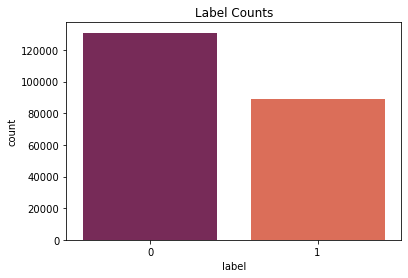

In [5]:
# Histogram of labels
sns.countplot(x=train_data['label'], palette='rocket').set(title='Label Counts');

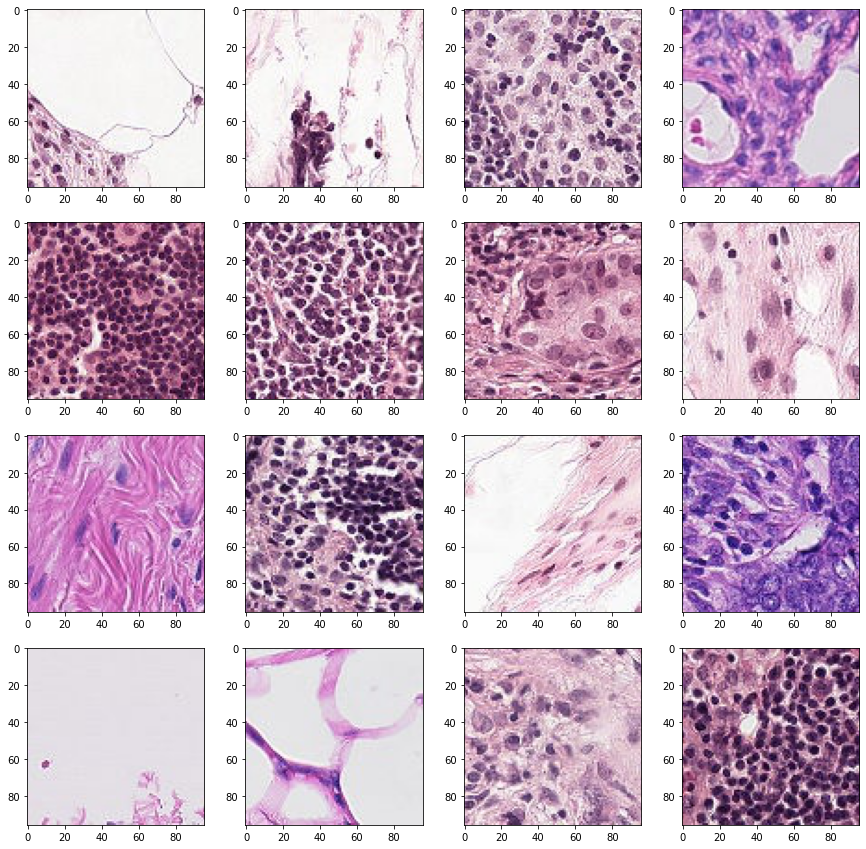

In [6]:
# Preview some images
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for image, axis in enumerate(ax.flat):
    files = str(train_dir + train_data.id[image] + '.tif')
    image = io.imread(files)
    axis.imshow(image)

# Model Architecture
Based on the problem description and initial inspection of the data, this seems like a straightforward binary classification problem, suited well for a CNN. We will set this up using a Keras library, and then after we have our baseline set up, check out some hyperparameter tuning.

To start, we'll setup our CNN with the following structure:
- 2D Conv Layer
- 2D Conv Layer
- Max Pooling Layer
- 2D Conv Layer
- 2D Conv Layer
- Max Pooling Layer
- Flatten
- Output w/ Sigmoid Activation Function

We want to use the sigmoid activation function on the output because we have a binary classification problem. We will also normalize the images prior to training by dividing by 255, so that they have values between 0 and 1. 

We'll split the training data into training and validation (80/20) so we can check our accuracy before we run against the test set. We'll use a batch size of 256 to ensure smaller variance.

In [7]:
# Prep data by making labels strings and id's tifs
train_data['id'] = train_data['id']+'.tif'
train_data['label'] = train_data['label'].astype(str)

# Split into training and validation data sets
# Normalize by 255
data_gen = ImageDataGenerator(rescale=1./255., validation_split=0.20)

# Training data
train_generator = data_gen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_dir,
    x_col="id",
    y_col="label",
    subset="training",
    class_mode="binary",
    batch_size=256,
    seed=1,
    target_size=(96,96))

# Validation data
valid_generator = data_gen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_dir,
    x_col="id",
    y_col="label",
    subset="validation",
    class_mode="binary",
    batch_size=256,
    seed=1,
    target_size=(96,96)) 

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [8]:
# Build CNN
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=32, kernel_size=(3,3)))
cnn_model.add(Conv2D(filters=32, kernel_size=(3,3)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3)))
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))
    
cnn_model.build(input_shape=(256, 96, 96, 3)) 
cnn_model.compile(loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()

2023-02-04 16:38:44.489637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 16:38:44.601492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 16:38:44.602304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 16:38:44.604641: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (256, 94, 94, 32)         896       
_________________________________________________________________
conv2d_1 (Conv2D)            (256, 92, 92, 32)         9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (256, 46, 46, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (256, 44, 44, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (256, 42, 42, 64)         36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (256, 21, 21, 64)         0         
_________________________________________________________________
flatten (Flatten)            (256, 28224)              0

node zero
2023-02-04 16:38:46.844033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 16:38:46.844852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 16:38:46.845527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 16:38:46.846172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Now that we've got our model built, we'll start by training with 10 epochs and check out the accuracy and loss. Based on the results, we might make some changes to hyperparameters or architecture.

In [9]:
# train the model with 10 epochs
history_m = cnn_model.fit_generator(
                        train_generator,
                        epochs = 10,
                        validation_data = valid_generator)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-02-04 16:38:57.752364: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-02-04 16:39:01.506947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


688/688 [==============================] - 1973s 3s/step - loss: 0.6768 - accuracy: 0.6788 - val_loss: 0.4838 - val_accuracy: 0.7879
Epoch 2/10
688/688 [==============================] - 580s 844ms/step - loss: 0.5224 - accuracy: 0.7551 - val_loss: 0.4823 - val_accuracy: 0.7820
Epoch 3/10
688/688 [==============================] - 379s 552ms/step - loss: 0.4744 - accuracy: 0.7796 - val_loss: 0.4613 - val_accuracy: 0.7924
Epoch 4/10
688/688 [==============================] - 332s 483ms/step - loss: 0.4423 - accuracy: 0.7988 - val_loss: 0.4396 - val_accuracy: 0.8025
Epoch 5/10
688/688 [==============================] - 325s 472ms/step - loss: 0.4134 - accuracy: 0.8156 - val_loss: 0.4385 - val_accuracy: 0.8036
Epoch 6/10
688/688 [==============================] - 319s 464ms/step - loss: 0.3849 - accuracy: 0.8308 - val_loss: 0.4590 - val_accuracy: 0.7922
Epoch 7/10
688/688 [==============================] - 310s 450ms/step - loss: 0.3598 - accuracy: 0.8431 - val_loss: 0.4615 - val_accuracy

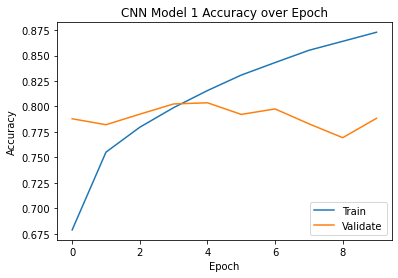

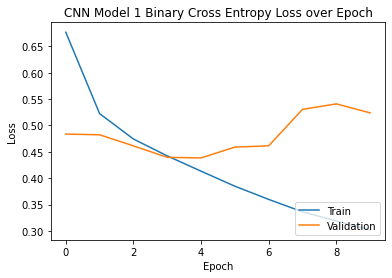

In [10]:
# plot accuracy per epoch 
plt.plot(history_m.history['accuracy'])
plt.plot(history_m.history['val_accuracy'])
plt.title('CNN Model 1 Accuracy over Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='lower right')
plt.show();

# plot loss per epoch
plt.plot(history_m.history['loss'])
plt.plot(history_m.history['val_loss'])
plt.title('CNN Model 1 Binary Cross Entropy Loss over Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show();

# Results and Analysis
Our first model did very well for the training data set, but not so well for the validation data set. The plots of accuracy and loss indicate potential overfitting to the training data.

It is likely we can do better, so we will make some adjustments to help with overfitting. In the next model, we add batch normalization and dropout layers. Batch normalization will make the model less sensitive to small changes in hyperparameters. Dropout will help signficiantly with overfitting to the training data. We also add relu activation functions to the conv2D layers. We will also add an Adam optimzier with a low learning rate, which should speed up the training time.

In [13]:
# Build CNN 2
cnn_model2 = Sequential()

cnn_model2.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
cnn_model2.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
cnn_model2.add(MaxPooling2D(pool_size=(2,2)))
cnn_model2.add(Dropout(0.1))
cnn_model2.add(BatchNormalization())
cnn_model2.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
cnn_model2.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
cnn_model2.add(MaxPooling2D(pool_size=(2,2)))
cnn_model2.add(Dropout(0.1))
cnn_model2.add(BatchNormalization())
cnn_model2.add(Flatten())
cnn_model2.add(Dense(1, activation='sigmoid'))

cnn_model2.build(input_shape=(256, 96, 96, 3)) 
adam_optimizer = Adam(learning_rate=0.0001)
cnn_model2.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam_optimizer)

cnn_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (256, 94, 94, 32)         896       
_________________________________________________________________
conv2d_9 (Conv2D)            (256, 92, 92, 32)         9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (256, 46, 46, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (256, 46, 46, 32)         0         
_________________________________________________________________
batch_normalization_2 (Batch (256, 46, 46, 32)         128       
_________________________________________________________________
conv2d_10 (Conv2D)           (256, 44, 44, 64)         18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (256, 42, 42, 64)        

In [14]:
# train the model with 10 epochs
history_m2 = cnn_model2.fit_generator(
                        train_generator,
                        epochs = 10,
                        validation_data = valid_generator)

Epoch 1/10
688/688 [==============================] - 313s 453ms/step - loss: 0.4711 - accuracy: 0.7919 - val_loss: 0.5301 - val_accuracy: 0.7428
Epoch 2/10
688/688 [==============================] - 320s 465ms/step - loss: 0.3796 - accuracy: 0.8389 - val_loss: 0.3734 - val_accuracy: 0.8459
Epoch 3/10
688/688 [==============================] - 311s 452ms/step - loss: 0.3455 - accuracy: 0.8552 - val_loss: 0.5659 - val_accuracy: 0.7841
Epoch 4/10
688/688 [==============================] - 308s 447ms/step - loss: 0.3157 - accuracy: 0.8685 - val_loss: 0.5066 - val_accuracy: 0.8105
Epoch 5/10
688/688 [==============================] - 310s 451ms/step - loss: 0.2941 - accuracy: 0.8782 - val_loss: 0.3479 - val_accuracy: 0.8578
Epoch 6/10
688/688 [==============================] - 308s 448ms/step - loss: 0.2764 - accuracy: 0.8869 - val_loss: 0.3752 - val_accuracy: 0.8391
Epoch 7/10
688/688 [==============================] - 315s 458ms/step - loss: 0.2621 - accuracy: 0.8935 - val_loss: 0.2806 -

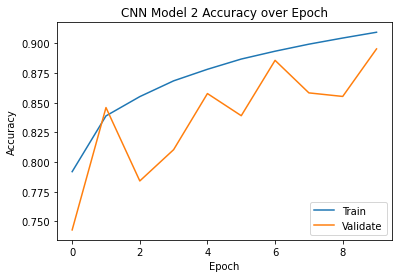

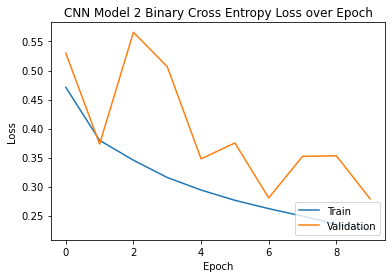

In [15]:
# plot accuracy per epoch 
plt.plot(history_m2.history['accuracy'])
plt.plot(history_m2.history['val_accuracy'])
plt.title('CNN Model 2 Accuracy over Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='lower right')
plt.show();

# plot loss per epoch
plt.plot(history_m2.history['loss'])
plt.plot(history_m2.history['val_loss'])
plt.title('CNN Model 2 Binary Cross Entropy Loss over Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show();

After adding an optimizer, relu activation functions, batch normalization, and dropout layers, the loss and accuracy for the validation data definitely has started to improve. This indicates we should get fairly well performance against the test data. The performance might be improved in the future by adding more conv2d layers and changing the filter size. Now we'll create the test data for submission.

In [19]:
# set up test data
datagentest = ImageDataGenerator(rescale=1./255.)

test_gen = datagentest.flow_from_dataframe(
    dataframe=test_data,
    directory=test_dir,
    x_col='id', 
    y_col=None,
    target_size=(96,96),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [21]:
# create submission data
predicts = cnn_model2.predict(test_gen, verbose=1)
predicts = np.transpose(predicts)[0]
submission = pd.DataFrame()
submission['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predicts))
submission.to_csv('submission.csv', index=False)

57458/57458 [==============================] - 515s 9ms/step


# Conclusions
Our model 2 seemed to do well against the training and validation data sets. The first model seemed to overfit quite a bit to the training data, so we used dropout layers and batch normalization in the second model to improve upon this. We also added relu activation functions, and used an adam optimizer to improve the training time and used a small learning rate. This seemed to help the validation data sets. In the future, we could add more conv2d layers with different filter sizes. We could also shuffle the training data, and rotate some of the images to improve the randomness.